# Работу выполнил студент группы 3825М1сФИ1 Кузнецов Артём

## Данный датасет содержит разнообразную информацию, в том числе сведения о бронировании, данные о клиентах и особенности бронирования, что поможет решить задачу классификации о прогнозе отмены бронирования отеля.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [2]:
df = pd.read_csv("booking_modified.csv")

## Разведочный анализ данных

In [3]:
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0.0,0.0,88.00,0.0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0.0,0.0,106.68,1.0,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0.0,0.0,50.00,0.0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0.0,0.0,100.00,1.0,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0.0,0.0,77.00,0.0,4/11/2018,Canceled


In [4]:
df.shape

(35770, 17)

Вид таблицы

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35770 entries, 0 to 35769
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                35770 non-null  object 
 1   number of adults          35770 non-null  int64  
 2   number of children        35770 non-null  int64  
 3   number of weekend nights  35770 non-null  int64  
 4   number of week nights     35770 non-null  int64  
 5   type of meal              35770 non-null  object 
 6   car parking space         35770 non-null  int64  
 7   room type                 35770 non-null  object 
 8   lead time                 35770 non-null  int64  
 9   market segment type       35770 non-null  object 
 10  repeated                  35770 non-null  int64  
 11  P-C                       35432 non-null  float64
 12  P-not-C                   35429 non-null  float64
 13  average price             35770 non-null  float64
 14  specia

## Обработка пропущенных значений

In [6]:
df.isnull().sum()

,0
Booking_ID,0
number of adults,0
number of children,0
number of weekend nights,0
number of week nights,0
type of meal,0
car parking space,0
room type,0
lead time,0
market segment type,0


In [7]:
df = df.dropna(subset=['P-C', 'P-not-C', 'special requests'])
df.isna().sum()

,0
Booking_ID,0
number of adults,0
number of children,0
number of weekend nights,0
number of week nights,0
type of meal,0
car parking space,0
room type,0
lead time,0
market segment type,0


In [8]:
df.shape

(34807, 17)

## Обработка выбросов

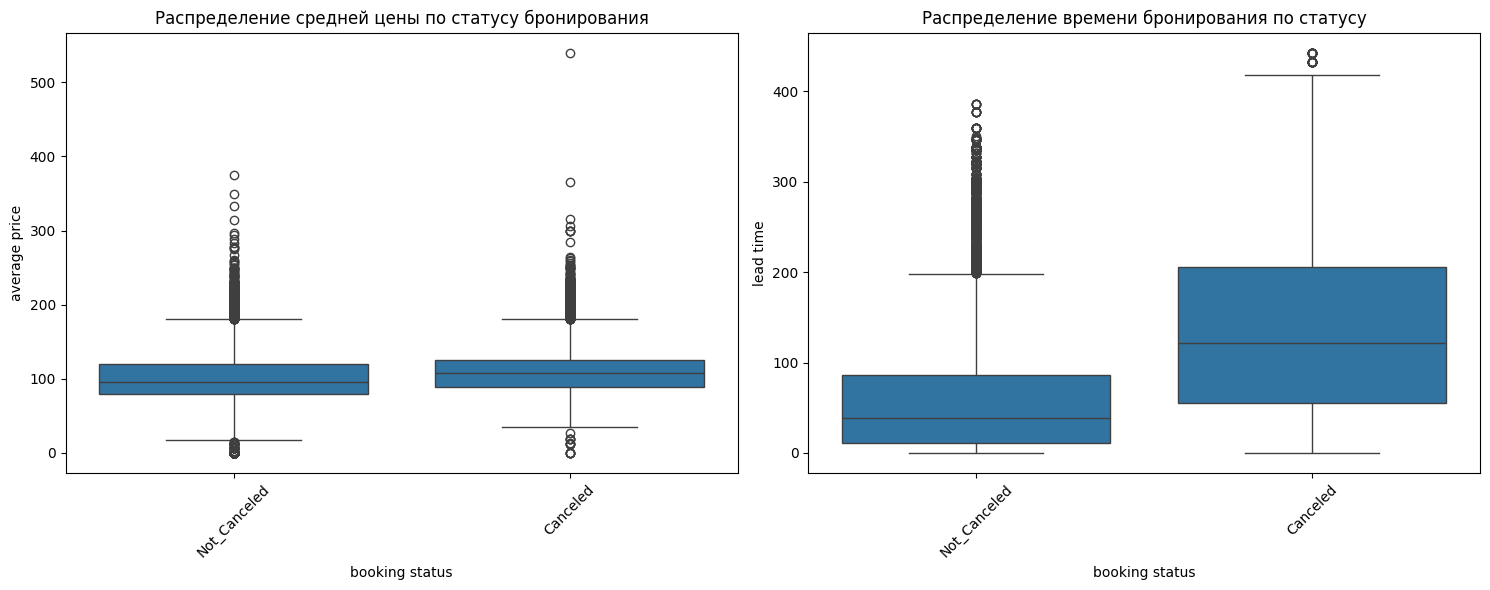

In [9]:
def boxplot():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.boxplot(data=df, x='booking status', y='average price', ax=axes[0])
    axes[0].set_title('Распределение средней цены по статусу бронирования')
    axes[0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df, x='booking status', y='lead time', ax=axes[1])
    axes[1].set_title('Распределение времени бронирования по статусу')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

boxplot()

In [10]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'average price')
df = remove_outliers_iqr(df, 'lead time')

print(f"Исходный размер датасета: {len(df)}")
print(f"Размер после удаления выбросов: {len(df)}")

Исходный размер датасета: 29776
Размер после удаления выбросов: 29776


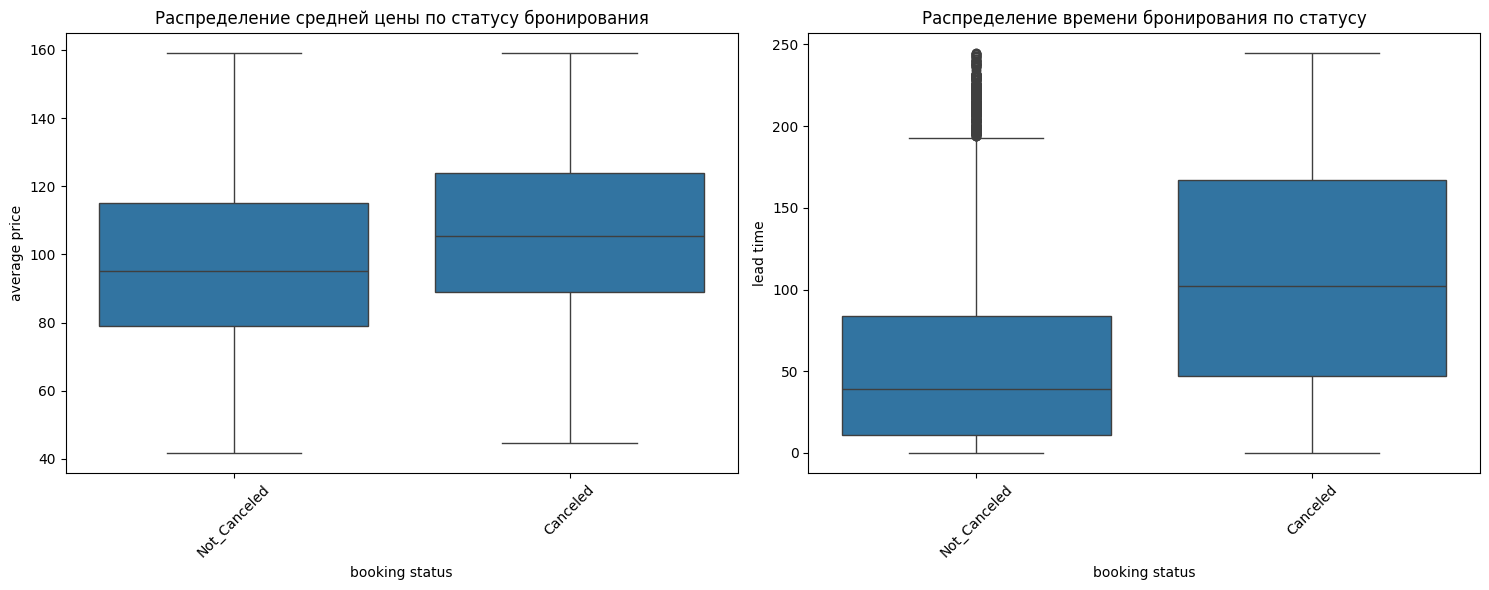

In [11]:
boxplot()

## Основные характеристики

In [12]:
df.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000,29776.000000
mean,1.823448,0.066497,0.831945,2.217591,0.029890,70.425275,0.025289,0.024315,0.149281,100.341074,0.615462
std,0.511525,0.302374,0.879490,1.429135,0.170286,62.955955,0.157004,0.387218,1.766822,24.903717,0.776849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.760000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.407500,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,54.000000,0.000000,0.000000,0.000000,97.710000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,109.000000,0.000000,0.000000,0.000000,118.800000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,245.000000,1.000000,13.000000,58.000000,159.200000,5.000000


## Обработка категориальных признаков

In [13]:
print("Booking_ID unique:", df['Booking_ID'].nunique())
print("type of meal unique:", df['type of meal'].nunique())
print("room type unique:", df['room type'].nunique())
print("market segment type unique:", df['market segment type'].nunique())
print("date of reservation unique:", df['date of reservation'].nunique())
print("booking status unique:", df['booking status'].nunique())

Booking_ID unique: 29776
type of meal unique: 3
room type unique: 5
market segment type unique: 4
date of reservation unique: 552
booking status unique: 2


In [14]:
cols_to_drop = ['Booking_ID']
df = df.drop(columns=cols_to_drop)
df.head()

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0.0,0.0,88.00,0.0,10/2/2015,Not_Canceled
1,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0.0,0.0,106.68,1.0,11/6/2018,Not_Canceled
2,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0.0,0.0,50.00,0.0,2/28/2018,Canceled
3,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0.0,0.0,100.00,1.0,5/20/2017,Canceled
4,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0.0,0.0,77.00,0.0,4/11/2018,Canceled


In [15]:
categorical_columns = ['type of meal', 'room type', 'market segment type']

df = pd.get_dummies(df, columns=categorical_columns)
print(f"Размерность после One-Hot: {df.shape}")

df['date of reservation'] = pd.to_datetime(df['date of reservation'], errors='coerce')

df = df.dropna(subset=['date of reservation'])

df['date of reservation'] = df['date of reservation'].fillna(pd.Timestamp('2020-01-01'))

df['year'] = df['date of reservation'].dt.year
df['month'] = df['date of reservation'].dt.month
df['day'] = df['date of reservation'].dt.day

df = df.drop('date of reservation', axis=1)
df

Размерность после One-Hot: (29776, 25)


,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,market segment type_Aviation,market segment type_Corporate,market segment type_Offline,market segment type_Online,year,month,day
0,1,1,2,5,0,224,0,0.0,0.0,88.00,...,False,False,False,False,False,True,False,2015,10,2
1,1,0,1,3,0,5,0,0.0,0.0,106.68,...,False,False,False,False,False,False,True,2018,11,6
2,2,1,1,3,0,1,0,0.0,0.0,50.00,...,False,False,False,False,False,False,True,2018,2,28
3,1,0,0,2,0,211,0,0.0,0.0,100.00,...,False,False,False,False,False,False,True,2017,5,20
4,1,0,1,2,0,48,0,0.0,0.0,77.00,...,False,False,False,False,False,False,True,2018,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35764,2,0,1,1,0,48,0,0.0,0.0,94.50,...,False,False,False,False,False,False,True,2018,4,11
35766,2,0,1,3,0,34,0,0.0,0.0,107.55,...,False,False,False,False,False,False,True,2017,10,15
35767,2,0,1,3,0,83,0,0.0,0.0,105.61,...,True,False,False,False,False,False,True,2018,12,26
35768,3,0,0,4,0,121,0,0.0,0.0,96.90,...,False,False,False,False,False,True,False,2018,7,6


## Корреляционная матрица

In [16]:
corr_matrix = df.corr(numeric_only = True)
corr_matrix

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,market segment type_Aviation,market segment type_Corporate,market segment type_Offline,market segment type_Online,year,month,day
number of adults,1.000000,-0.048172,0.113298,0.118085,-0.003000,0.129400,-0.195153,-0.043388,-0.120116,0.255813,...,0.273629,-0.007028,0.041979,-0.101334,-0.304383,-0.082155,0.247369,0.048423,0.023455,0.024855
number of children,-0.048172,1.000000,0.032082,0.024335,-0.005221,0.012670,-0.033214,-0.013511,-0.017827,0.146911,...,-0.043119,0.016516,0.356963,-0.014112,-0.049187,-0.088653,0.110656,0.037420,0.005993,0.028587
number of weekend nights,0.113298,0.032082,1.000000,0.183177,-0.032509,0.099968,-0.061445,-0.020351,-0.020074,-0.041639,...,0.069630,-0.006269,0.021324,0.021842,-0.120266,-0.053440,0.109179,0.057928,-0.012911,0.024918
number of week nights,0.118085,0.024335,0.183177,1.000000,-0.045361,0.193786,-0.094896,-0.026983,-0.043574,0.003365,...,0.128333,0.015364,0.014638,0.027045,-0.135355,-0.019696,0.084453,0.024721,0.030577,-0.002928
car parking space,-0.003000,-0.005221,-0.032509,-0.045361,1.000000,-0.049476,0.126993,0.032879,0.076021,0.041302,...,0.001184,-0.003150,-0.007115,0.007304,0.095033,-0.093680,0.038418,0.011669,-0.010130,0.002181
lead time,0.129400,0.012670,0.099968,0.193786,-0.049476,1.000000,-0.150331,-0.050741,-0.081832,-0.014499,...,-0.003675,-0.011042,-0.017065,-0.066220,-0.203686,0.151270,-0.028913,0.122790,0.078336,-0.001594
repeated,-0.195153,-0.033214,-0.061445,-0.094896,0.126993,-0.150331,1.000000,0.390414,0.523992,-0.155825,...,-0.047672,0.029722,-0.010559,0.043404,0.459615,-0.059386,-0.186037,-0.013162,0.007773,-0.012785
P-C,-0.043388,-0.013511,-0.020351,-0.026983,0.032879,-0.050741,0.390414,1.000000,0.482414,-0.060789,...,-0.013148,-0.002558,-0.005150,0.002763,0.097311,-0.019325,-0.032166,0.005061,-0.039334,-0.010548
P-not-C,-0.120116,-0.017827,-0.020074,-0.043574,0.076021,-0.081832,0.523992,0.482414,1.000000,-0.102083,...,-0.029529,0.019414,-0.006678,0.002341,0.290961,-0.047489,-0.105074,0.029919,-0.004051,0.001633
average price,0.255813,0.146911,-0.041639,0.003365,0.041302,-0.014499,-0.155825,-0.060789,-0.102083,1.000000,...,0.338739,0.055592,0.148422,0.001587,-0.193536,-0.262581,0.346504,0.183511,0.078797,-0.014030


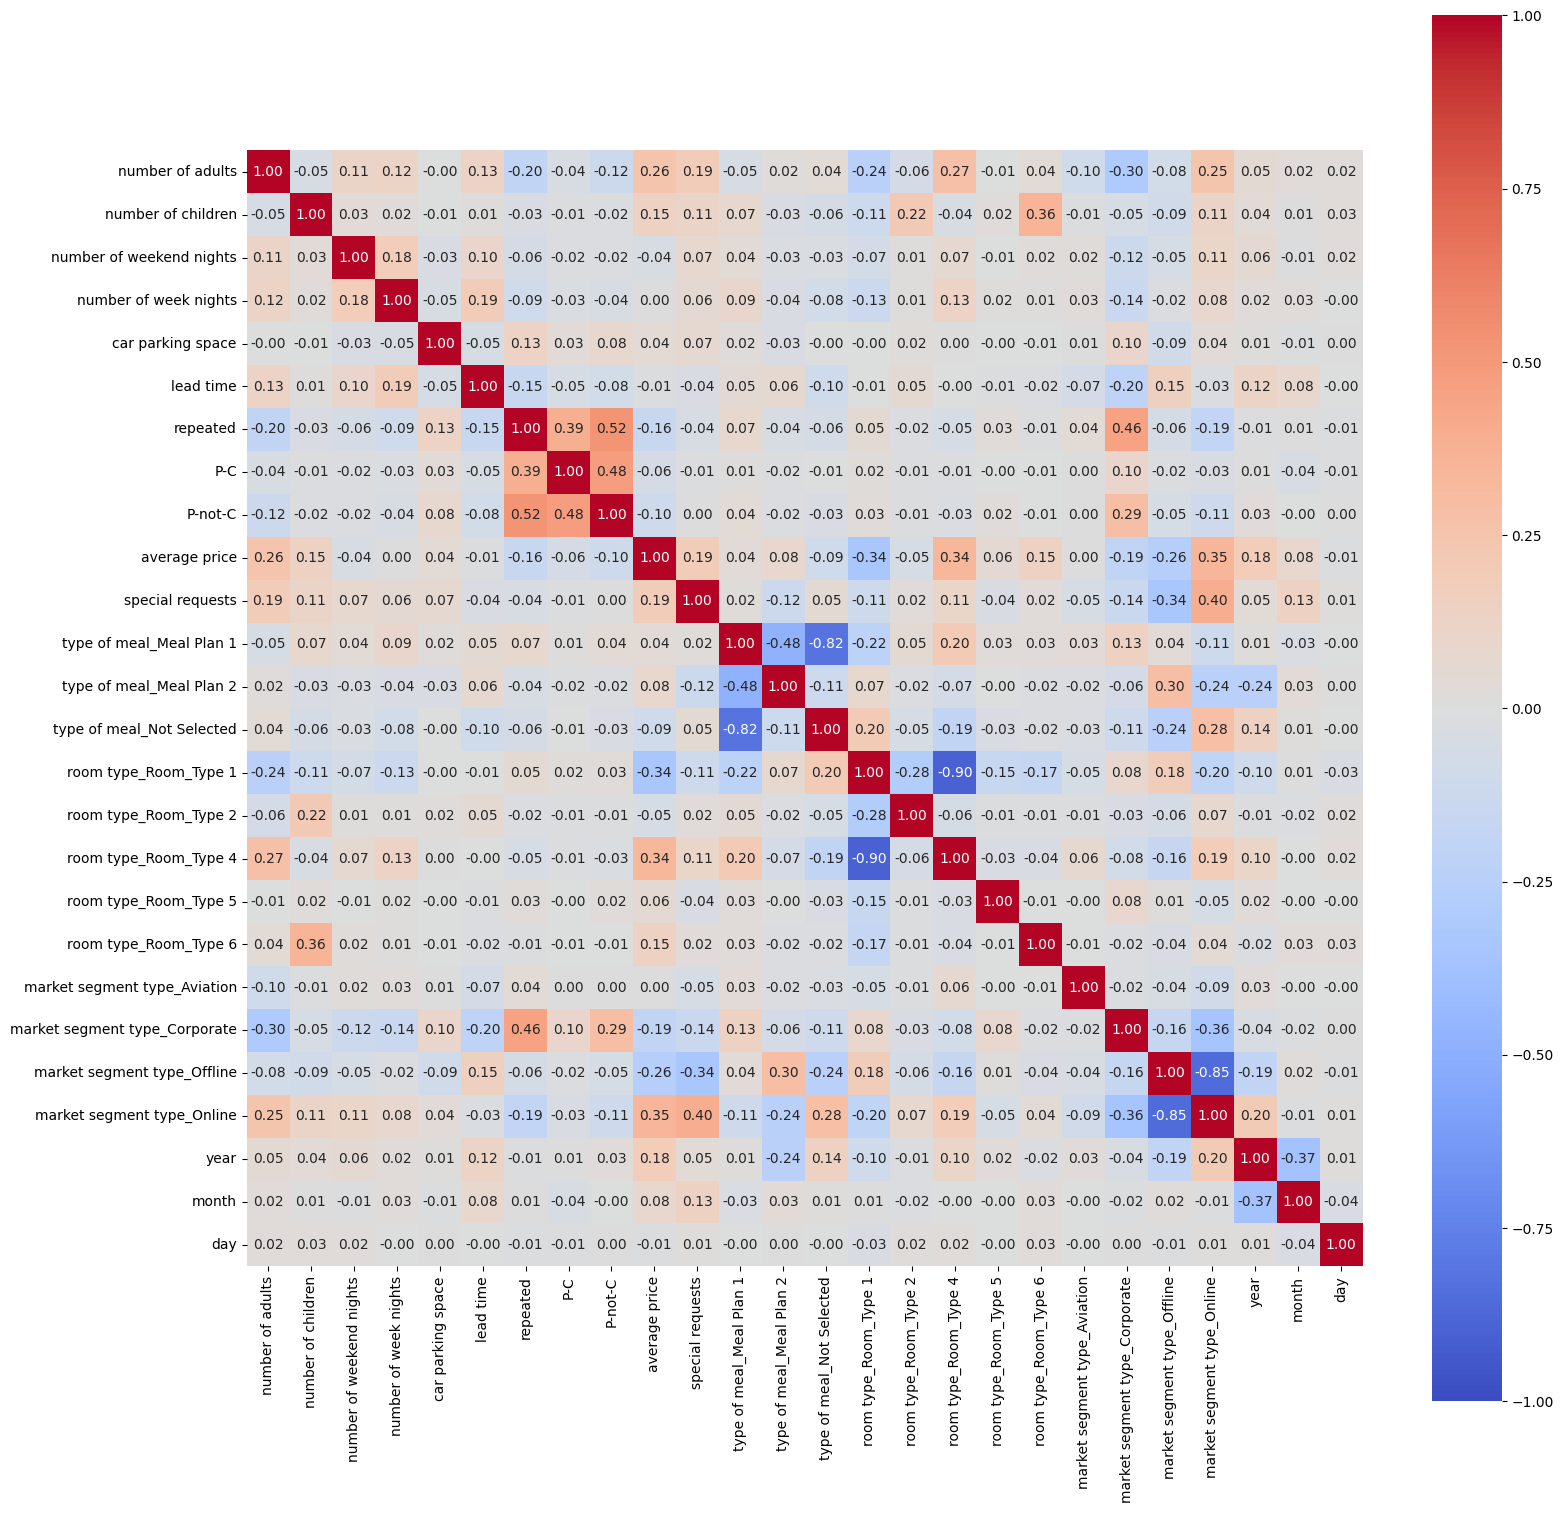

In [17]:
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.show()

## Разбиение данных и нормализация

In [18]:
y = df['booking status']
X = df.drop('booking status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Запуск классификатора

Модель: LogisticRegression
Точность на обучающей выборке: 0.7998
Точность на тестовой выборке: 0.8102
Ошибка на обучающей выборке: 0.2002
Ошибка на тестовой выборке: 0.1898


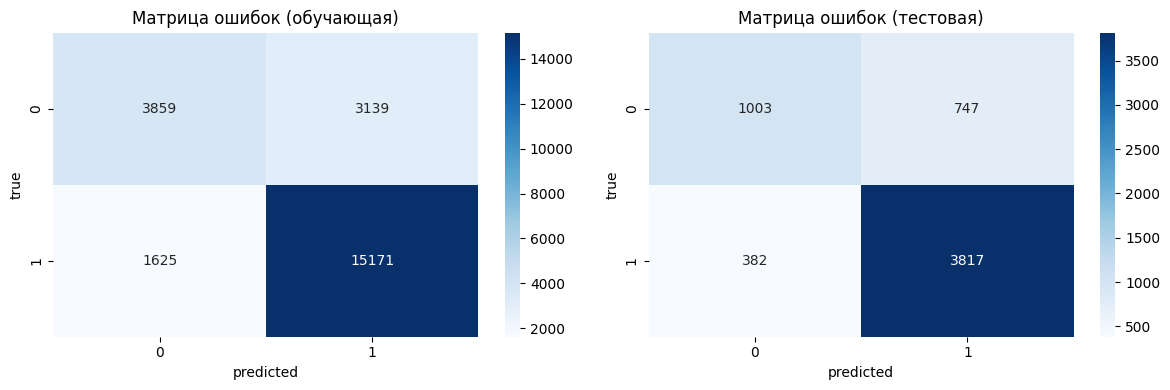

In [19]:
print(f"Модель: LogisticRegression")
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_test = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

train_error = 1 - acc_train
test_error = 1 - acc_test

print(f"Точность на обучающей выборке: {acc_train:.4f}")
print(f"Точность на тестовой выборке: {acc_test:.4f}")

print(f"Ошибка на обучающей выборке: {train_error:.4f}")
print(f"Ошибка на тестовой выборке: {test_error:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Матрица ошибок (обучающая)")
ax1.set_xlabel("predicted")
ax1.set_ylabel("true")

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title("Матрица ошибок (тестовая)")
ax2.set_xlabel("predicted")
ax2.set_ylabel("true")

plt.tight_layout()
plt.show()

Топ-10 самых важных признаков:
                        feature  importance
10             special requests    1.154641
5                     lead time    1.073020
9                 average price    0.486629
21  market segment type_Offline    0.427904
22   market segment type_Online    0.407130
6                      repeated    0.401386
4             car parking space    0.281080
23                         year    0.151227
8                       P-not-C    0.137207
2      number of weekend nights    0.133926


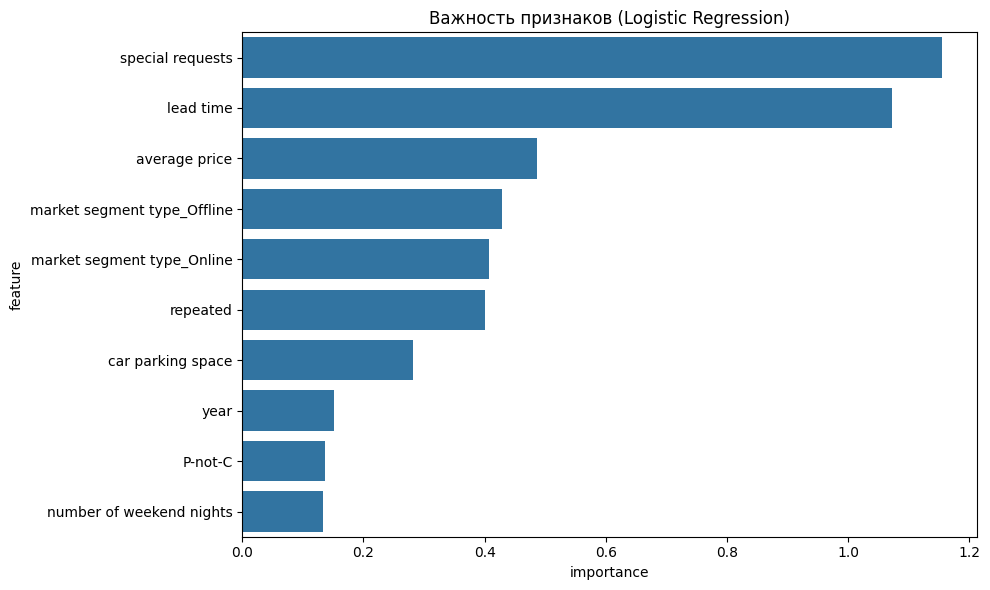

In [20]:
feature_importance = abs(model.coef_[0])
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Топ-10 самых важных признаков:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Важность признаков (Logistic Regression)')
plt.tight_layout()
plt.show()

## Подбор гипермараметров

In [21]:
parameters = {
    'model': LogisticRegression(random_state=42, max_iter=1000),
    'params': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }
}

grid_search = GridSearchCV(
    parameters['model'],
    parameters['params'],
    cv=3,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'C': 10, 'solver': 'lbfgs'}


## Ошибки на обучающей и тестовой выборках

Модель: LogisticRegression
Точность на обучающей выборке: 0.7998
Точность на тестовой выборке: 0.8102
Ошибка на обучающей выборке: 0.2002
Ошибка на тестовой выборке: 0.1898


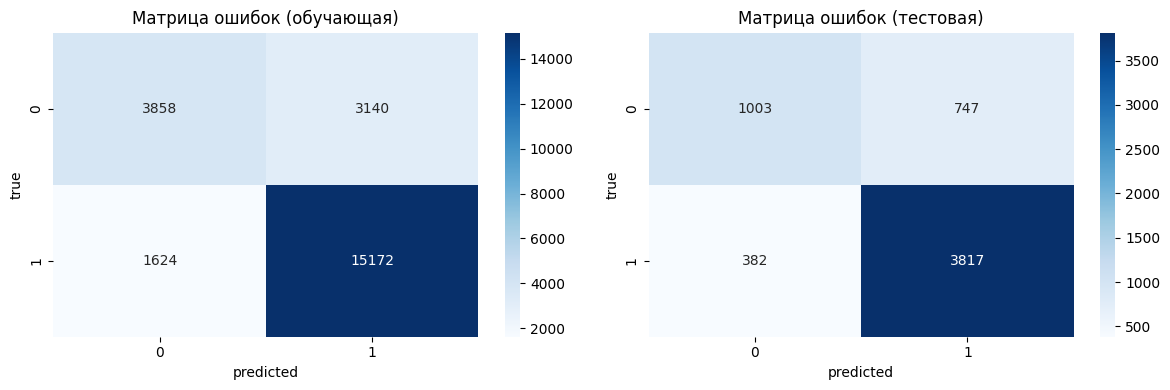

In [22]:
print(f"Модель: LogisticRegression")
model = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_test = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

train_error = 1 - acc_train
test_error = 1 - acc_test

print(f"Точность на обучающей выборке: {acc_train:.4f}")
print(f"Точность на тестовой выборке: {acc_test:.4f}")

print(f"Ошибка на обучающей выборке: {train_error:.4f}")
print(f"Ошибка на тестовой выборке: {test_error:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Матрица ошибок (обучающая)")
ax1.set_xlabel("predicted")
ax1.set_ylabel("true")

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title("Матрица ошибок (тестовая)")
ax2.set_xlabel("predicted")
ax2.set_ylabel("true")

plt.tight_layout()
plt.show()

## Запуск других классификаторов с подбором гиперпараметров

In [23]:
models_to_tune = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [3, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30]
        }
    },
}

best_params = {}
for name, config in models_to_tune.items():
    print(f"Подбор параметров для {name}")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='accuracy'
    )
    grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_

    print(f"Лучшие параметры {name}: {grid_search.best_params_}")

print("Лучшие параметры:")
for model, params in best_params.items():
    print(f"{model}: {params}")

Подбор параметров для KNN
Лучшие параметры KNN: {'n_neighbors': 15, 'weights': 'distance'}
Подбор параметров для GradientBoosting
Лучшие параметры GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Подбор параметров для Random Forest
Лучшие параметры Random Forest: {'max_depth': None, 'n_estimators': 200}
Лучшие параметры:
KNN: {'n_neighbors': 15, 'weights': 'distance'}
GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Random Forest: {'max_depth': None, 'n_estimators': 200}


Модель: KNN
Точность на обучающей выборке: 0.9942
Точность на тестовой выборке: 0.8711
Ошибка на обучающей выборке: 0.0058
Ошибка на тестовой выборке: 0.1289


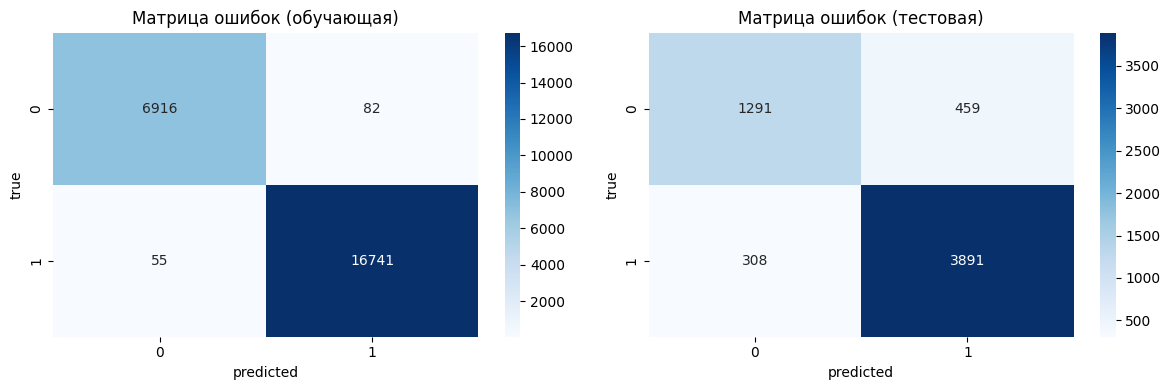



Модель: GradientBoosting
Точность на обучающей выборке: 0.8887
Точность на тестовой выборке: 0.8828
Ошибка на обучающей выборке: 0.1113
Ошибка на тестовой выборке: 0.1172


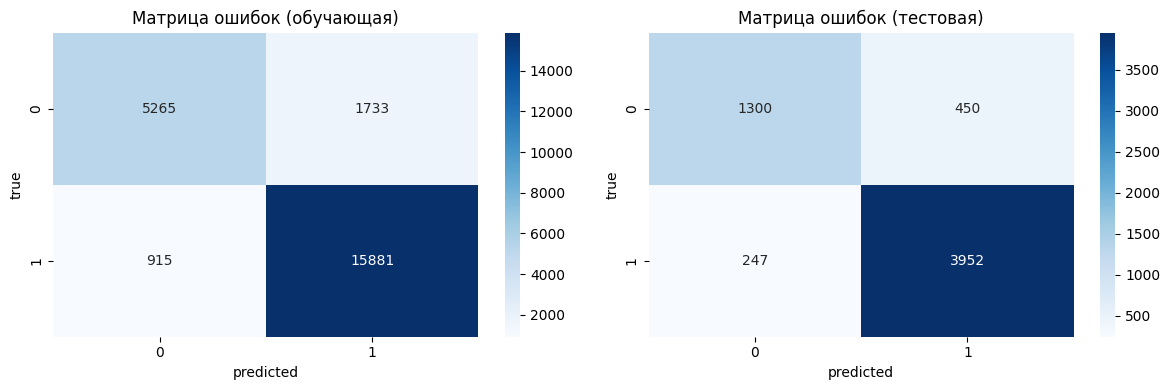



Модель: RandomForestClassifier
Точность на обучающей выборке: 0.9942
Точность на тестовой выборке: 0.9012
Ошибка на обучающей выборке: 0.0058
Ошибка на тестовой выборке: 0.0988


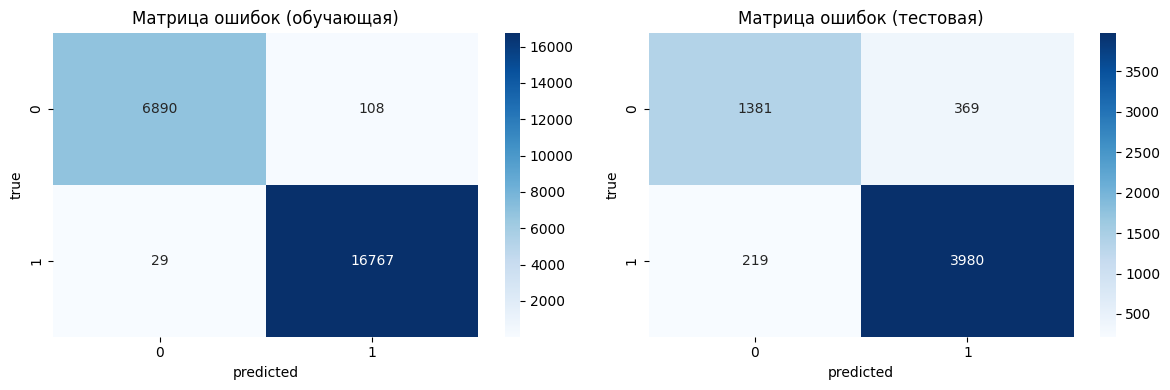

In [24]:
models = {
    "KNN": KNeighborsClassifier(**best_params['KNN']),
    "GradientBoosting": GradientBoostingClassifier(**best_params['GradientBoosting']),
    "RandomForestClassifier": RandomForestClassifier(**best_params['Random Forest'])
}

for name, model in models.items():
    print(f"Модель: {name}")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)

    train_error = 1 - acc_train
    test_error = 1 - acc_test

    print(f"Точность на обучающей выборке: {acc_train:.4f}")
    print(f"Точность на тестовой выборке: {acc_test:.4f}")

    print(f"Ошибка на обучающей выборке: {train_error:.4f}")
    print(f"Ошибка на тестовой выборке: {test_error:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    cm_train = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=ax1)
    ax1.set_title("Матрица ошибок (обучающая)")
    ax1.set_xlabel("predicted")
    ax1.set_ylabel("true")

    cm_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax2)
    ax2.set_title("Матрица ошибок (тестовая)")
    ax2.set_xlabel("predicted")
    ax2.set_ylabel("true")

    plt.tight_layout()
    plt.show()
    print("\n")

## Борьба с несбалансированностью классов

Распределение классов:
booking status
Not_Canceled    20995
Canceled         8748
Name: count, dtype: int64


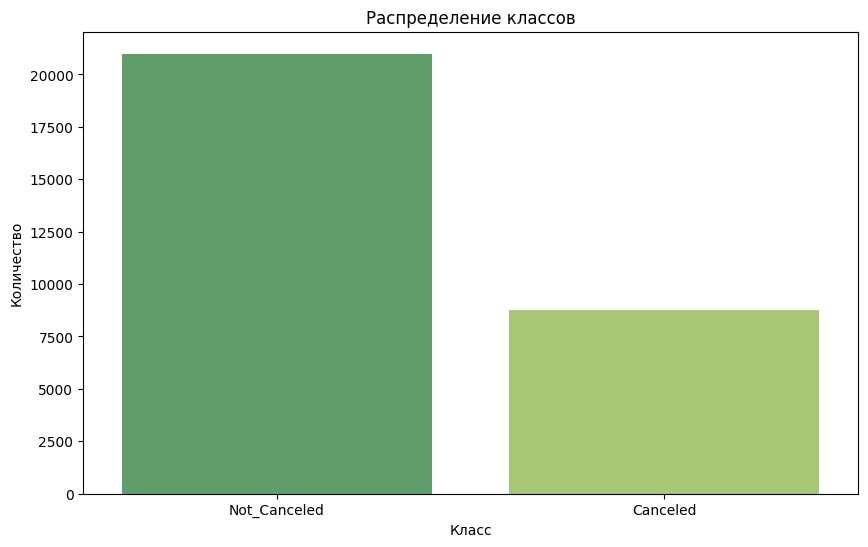

In [25]:
class_distribution = df['booking status'].value_counts()
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values,
            hue=class_distribution.index, palette='summer', legend=False)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

In [26]:
print("До SMOTE:", Counter(y_train))

smoteenn = SMOTE(random_state=42)
X_train_smote, y_train_smote = smoteenn.fit_resample(X_train, y_train)

print("После SMOTE:", Counter(y_train_smote))

До SMOTE: Counter({'Not_Canceled': 16796, 'Canceled': 6998})
После SMOTE: Counter({'Canceled': 16796, 'Not_Canceled': 16796})


In [27]:
models_to_tune = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }
    },

    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [None, 10, 15, 20, 25, 30]
        }
    },
}

best_params = {}
for name, config in models_to_tune.items():
    print(f"Подбор параметров для {name}")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='accuracy'
    )
    grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_
    print(f"Лучшие параметры {name}: {grid_search.best_params_}")

print("Лучшие параметры:")
for model, params in best_params.items():
    print(f"{model}: {params}")

Подбор параметров для LogisticRegression
Лучшие параметры LogisticRegression: {'C': 10, 'solver': 'lbfgs'}
Подбор параметров для KNN
Лучшие параметры KNN: {'n_neighbors': 15, 'weights': 'distance'}
Подбор параметров для GradientBoosting
Лучшие параметры GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Подбор параметров для Random Forest
Лучшие параметры Random Forest: {'max_depth': 25, 'n_estimators': 250}
Лучшие параметры:
LogisticRegression: {'C': 10, 'solver': 'lbfgs'}
KNN: {'n_neighbors': 15, 'weights': 'distance'}
GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Random Forest: {'max_depth': 25, 'n_estimators': 250}


Модель: LogisticRegression
Точность на обучающей выборке: 0.7656
Точность на тестовой выборке: 0.7736
Ошибка на обучающей выборке: 0.2344
Ошибка на тестовой выборке: 0.2264


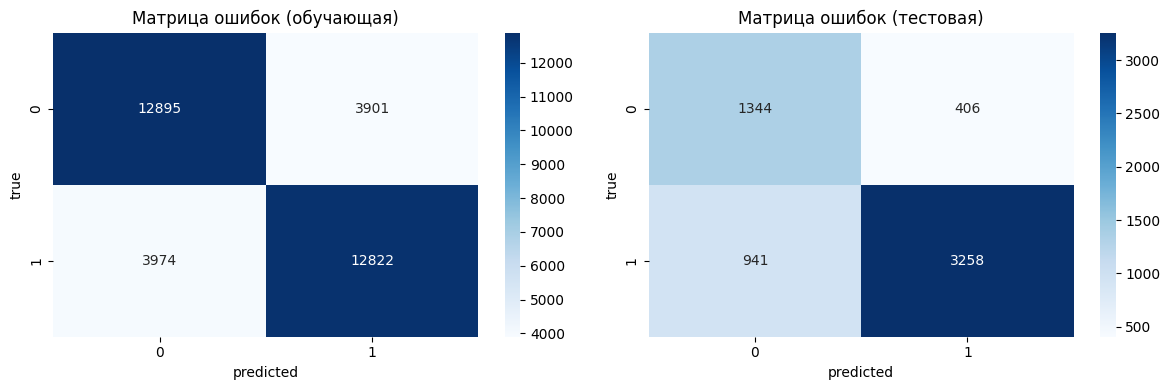



Модель: KNN
Точность на обучающей выборке: 0.9945
Точность на тестовой выборке: 0.8420
Ошибка на обучающей выборке: 0.0055
Ошибка на тестовой выборке: 0.1580


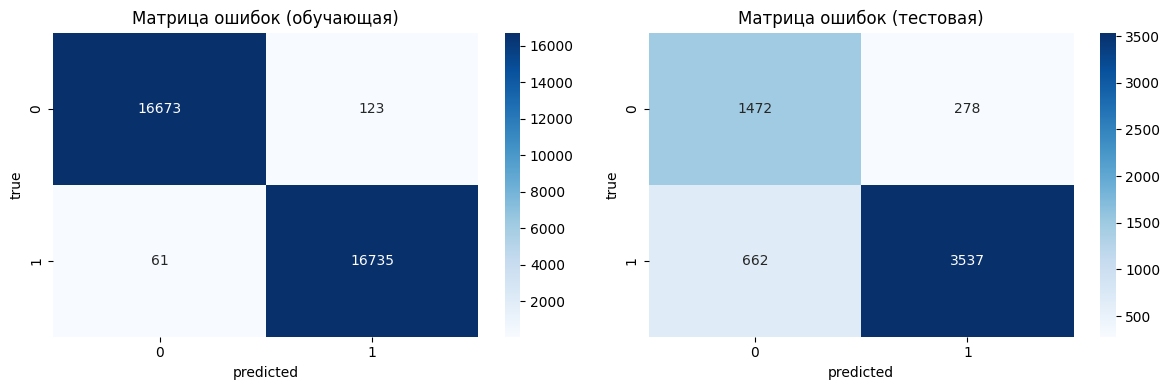



Модель: GradientBoosting
Точность на обучающей выборке: 0.9074
Точность на тестовой выборке: 0.8783
Ошибка на обучающей выборке: 0.0926
Ошибка на тестовой выборке: 0.1217


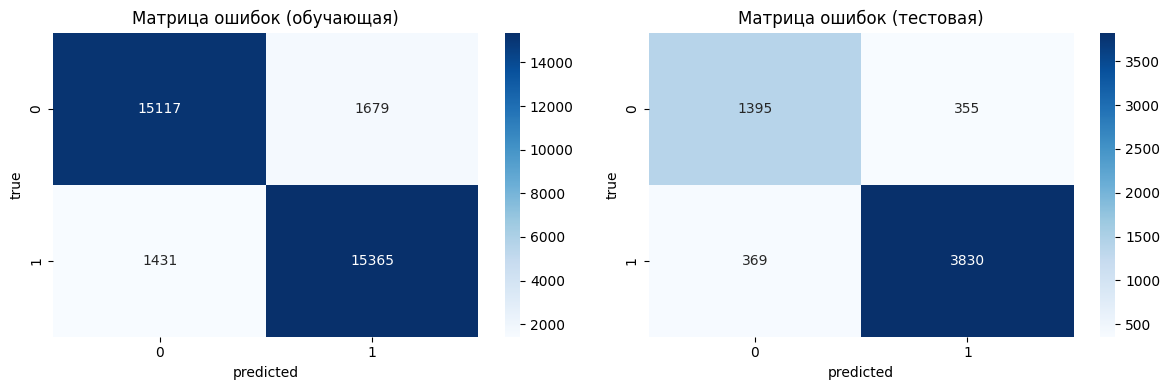



Модель: RandomForestClassifier
Точность на обучающей выборке: 0.9862
Точность на тестовой выборке: 0.9003
Ошибка на обучающей выборке: 0.0138
Ошибка на тестовой выборке: 0.0997


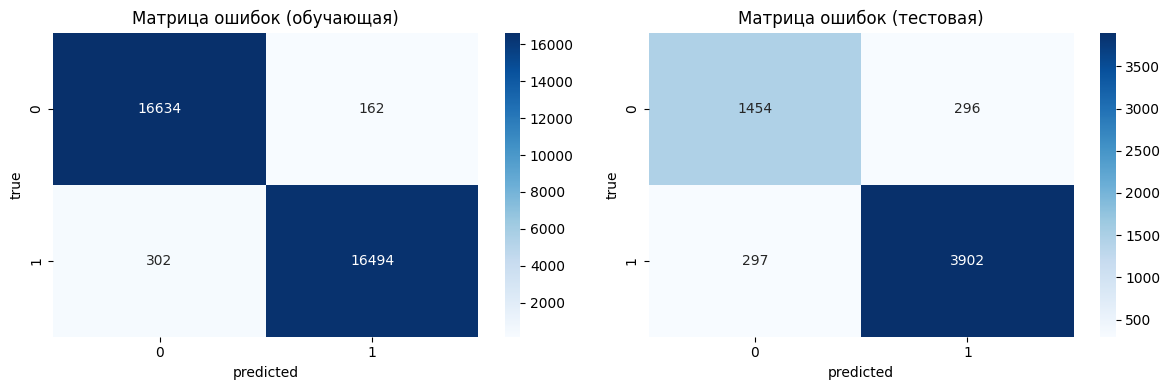

In [28]:
models = {
    "LogisticRegression": LogisticRegression(**best_params['LogisticRegression']),
    "KNN": KNeighborsClassifier(**best_params['KNN']),
    "GradientBoosting": GradientBoostingClassifier(**best_params['GradientBoosting']),
    "RandomForestClassifier": RandomForestClassifier(**best_params['Random Forest'])
}

for name, model in models.items():
    print(f"Модель: {name}")
    model.fit(X_train_smote, y_train_smote)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train_smote)

    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train_smote, y_pred_train)

    train_error = 1 - acc_train
    test_error = 1 - acc_test

    print(f"Точность на обучающей выборке: {acc_train:.4f}")
    print(f"Точность на тестовой выборке: {acc_test:.4f}")

    print(f"Ошибка на обучающей выборке: {train_error:.4f}")
    print(f"Ошибка на тестовой выборке: {test_error:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    cm_train = confusion_matrix(y_train_smote, y_pred_train)
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=ax1)
    ax1.set_title("Матрица ошибок (обучающая)")
    ax1.set_xlabel("predicted")
    ax1.set_ylabel("true")

    cm_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax2)
    ax2.set_title("Матрица ошибок (тестовая)")
    ax2.set_xlabel("predicted")
    ax2.set_ylabel("true")

    plt.tight_layout()
    plt.show()
    print("\n")

## Выявление и удаление сильно коррелированных признаков


In [29]:
X = df.drop('booking status', axis=1)
corr_matrix_X = X.corr(numeric_only = True)

high_corr_pairs = []
for i in range(len(corr_matrix_X.columns)):
    for j in range(i + 1, len(corr_matrix_X.columns)):
        colname_i = corr_matrix_X.columns[i]
        colname_j = corr_matrix_X.columns[j]
        correlation = corr_matrix_X.iloc[i, j]
        if abs(correlation) > 0.8:
            high_corr_pairs.append((colname_i, colname_j, correlation))

print("Сильно коррелированные пары признаков (абсолютная корреляция > 0.8):")
for p in high_corr_pairs:
    print(f"  {p[0]} vs {p[1]}: {p[2]:.2f}")

columns_to_drop = set()
for pair in high_corr_pairs:
    columns_to_drop.add(pair[1])

print("\nПризнаки, выбранные для удаления из-за высокой корреляции:")
print(list(columns_to_drop))

Сильно коррелированные пары признаков (абсолютная корреляция > 0.8):
  type of meal_Meal Plan 1 vs type of meal_Not Selected: -0.82
  room type_Room_Type 1 vs room type_Room_Type 4: -0.90
  market segment type_Offline vs market segment type_Online: -0.85

Признаки, выбранные для удаления из-за высокой корреляции:
['room type_Room_Type 4', 'type of meal_Not Selected', 'market segment type_Online']


In [30]:
columns_to_drop_list = list(columns_to_drop)
X_filtered = X.drop(columns=columns_to_drop_list)

print(f"\nИсходное количество признаков: {X.shape[1]}")
print(f"Количество признаков после удаления сильно коррелированных: {X_filtered.shape[1]}")


Исходное количество признаков: 26
Количество признаков после удаления сильно коррелированных: 23


In [31]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y
)

scaler_filtered = StandardScaler()
X_train_filtered_scaled = scaler_filtered.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler_filtered.transform(X_test_filtered)

print(f"\nРазмер X_train_filtered_scaled: {X_train_filtered_scaled.shape}")
print(f"Размер X_test_filtered_scaled: {X_test_filtered_scaled.shape}")
print(f"Размер y_train_filtered: {y_train_filtered.shape}")
print(f"Размер y_test_filtered: {y_test_filtered.shape}")


Размер X_train_filtered_scaled: (23794, 23)
Размер X_test_filtered_scaled: (5949, 23)
Размер y_train_filtered: (23794,)
Размер y_test_filtered: (5949,)


In [32]:
print("До SMOTE:", Counter(y_train_filtered))

smote = SMOTE(random_state=42)
X_train_smote_filtered, y_train_smote_filtered = smote.fit_resample(X_train_filtered_scaled, y_train_filtered)

print("После SMOTE:", Counter(y_train_smote_filtered))

До SMOTE: Counter({'Not_Canceled': 16796, 'Canceled': 6998})
После SMOTE: Counter({'Canceled': 16796, 'Not_Canceled': 16796})


In [33]:
models_to_tune = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [None, 10, 15, 20, 25, 30]
        }
    },
}

best_params_filtered = {}
for name, config in models_to_tune.items():
    print(f"Подбор параметров для {name}")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train_smote_filtered, y_train_smote_filtered)
    best_params_filtered[name] = grid_search.best_params_
    print(f"Лучшие параметры для {name}: {grid_search.best_params_}")

print("\nЛучшие параметры:")
for model_name, params in best_params_filtered.items():
    print(f"{model_name}: {params}")

Подбор параметров для LogisticRegression
Лучшие параметры для LogisticRegression: {'C': 0.1, 'solver': 'lbfgs'}
Подбор параметров для KNN
Лучшие параметры для KNN: {'n_neighbors': 3, 'weights': 'distance'}
Подбор параметров для GradientBoosting
Лучшие параметры для GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Подбор параметров для Random Forest
Лучшие параметры для Random Forest: {'max_depth': None, 'n_estimators': 300}

Лучшие параметры:
LogisticRegression: {'C': 0.1, 'solver': 'lbfgs'}
KNN: {'n_neighbors': 3, 'weights': 'distance'}
GradientBoosting: {'max_depth': 4, 'n_estimators': 300}
Random Forest: {'max_depth': None, 'n_estimators': 300}



Модель: LogisticRegression
Точность на обучающей выборке: 0.7664
Точность на тестовой выборке: 0.7741
Ошибка на обучающей выборке: 0.2336
Ошибка на тестовой выборке: 0.2259


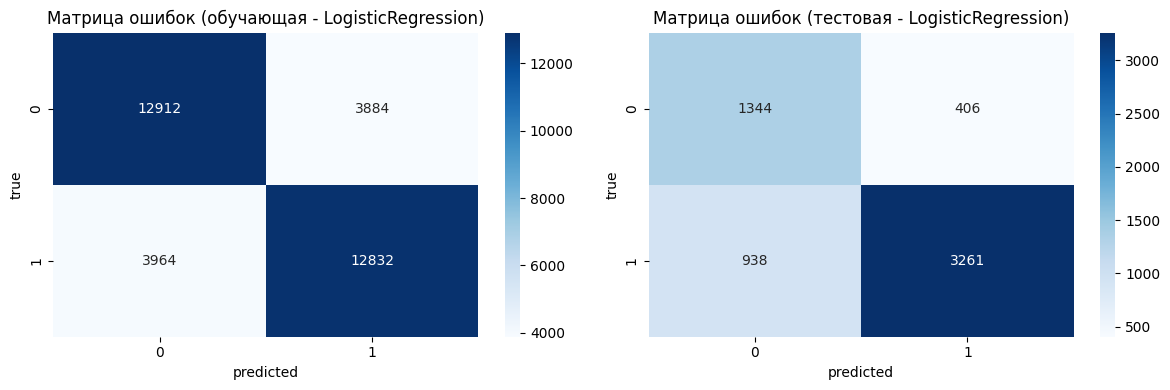


Модель: KNN
Точность на обучающей выборке: 0.9944
Точность на тестовой выборке: 0.8422
Ошибка на обучающей выборке: 0.0056
Ошибка на тестовой выборке: 0.1578


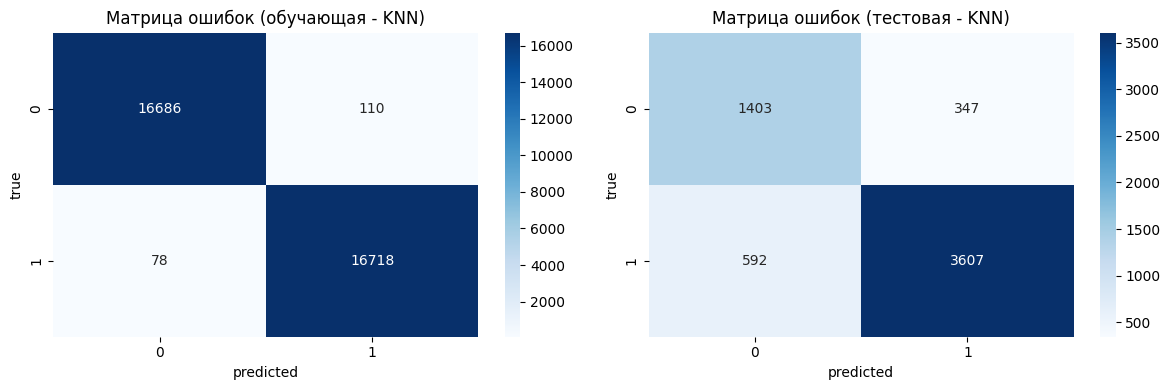


Модель: GradientBoosting
Точность на обучающей выборке: 0.9060
Точность на тестовой выборке: 0.8788
Ошибка на обучающей выборке: 0.0940
Ошибка на тестовой выборке: 0.1212


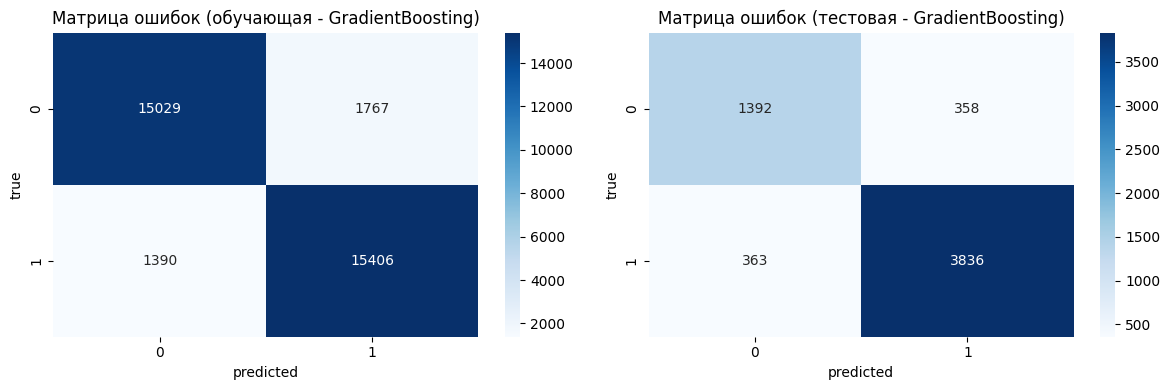


Модель: RandomForestClassifier
Точность на обучающей выборке: 0.9947
Точность на тестовой выборке: 0.8978
Ошибка на обучающей выборке: 0.0053
Ошибка на тестовой выборке: 0.1022


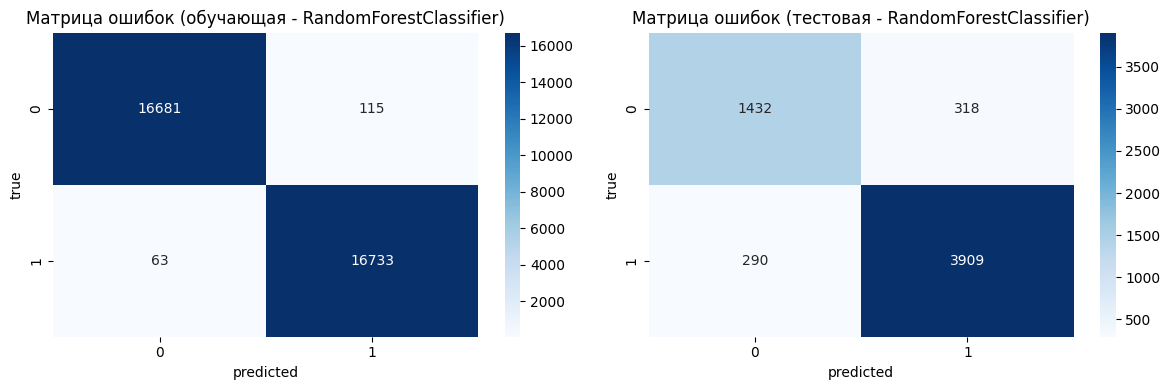

In [34]:
models_filtered = {
    "LogisticRegression": LogisticRegression(**best_params_filtered['LogisticRegression'], random_state=42),
    "KNN": KNeighborsClassifier(**best_params_filtered['KNN']),
    "GradientBoosting": GradientBoostingClassifier(**best_params_filtered['GradientBoosting'], random_state=42),
    "RandomForestClassifier": RandomForestClassifier(**best_params_filtered['Random Forest'], random_state=42)
}

results_filtered = {}

for name, model in models_filtered.items():
    print(f"\nМодель: {name}")
    model.fit(X_train_smote_filtered, y_train_smote_filtered)
    y_pred_test_filtered = model.predict(X_test_filtered_scaled)
    y_pred_train_filtered = model.predict(X_train_smote_filtered)

    acc_test_filtered = accuracy_score(y_test_filtered, y_pred_test_filtered)
    acc_train_filtered = accuracy_score(y_train_smote_filtered, y_pred_train_filtered)

    train_error_filtered = 1 - acc_train_filtered
    test_error_filtered = 1 - acc_test_filtered

    results_filtered[name] = {
        'train_accuracy': acc_train_filtered,
        'test_accuracy': acc_test_filtered,
        'train_error': train_error_filtered,
        'test_error': test_error_filtered
    }

    print(f"Точность на обучающей выборке: {acc_train_filtered:.4f}")
    print(f"Точность на тестовой выборке: {acc_test_filtered:.4f}")
    print(f"Ошибка на обучающей выборке: {train_error_filtered:.4f}")
    print(f"Ошибка на тестовой выборке: {test_error_filtered:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    cm_train_filtered = confusion_matrix(y_train_smote_filtered, y_pred_train_filtered)
    sns.heatmap(cm_train_filtered, annot=True, fmt="d", cmap="Blues", ax=ax1)
    ax1.set_title(f"Матрица ошибок (обучающая - {name})")
    ax1.set_xlabel("predicted")
    ax1.set_ylabel("true")

    cm_test_filtered = confusion_matrix(y_test_filtered, y_pred_test_filtered)
    sns.heatmap(cm_test_filtered, annot=True, fmt="d", cmap="Blues", ax=ax2)
    ax2.set_title(f"Матрица ошибок (тестовая - {name})")
    ax2.set_xlabel("predicted")
    ax2.set_ylabel("true")

    plt.tight_layout()
    plt.show()

Удаление коррелированных признаков почти не изменило качество моделей, поэтому этот шаг был не обязательным.

## Итог
### Вывод по каждой модели
1. Logistic Regression

После применения SMOTE точность заметно снизилась (с 0.8102 до 0.7736). Можно объяснить это тем, что линейная модель чувствительна к синтетическим данным и шуму. Удаление коррелированных признаков ничего существенно не изменило.

Данная модель стабильна, но работает хуже других, а также плохо переносит балансировку SMOTE.

2. KNN

До метода SMOTE на обучающей выборке точность составляла 0.9942, а на тестовой 0.8711. После SMOTE тестовая точность упала сильнее: 0.8420. Удаление коррелированных признаков почти не повлияло.

Модель KNN подходит для данной задачи, так как слишком нестабильна.

3. Gradient Boosting

До применения метода SMOTE точность на тестовой выборке составляла 0.8828, а после - немного снизилась до 0.8783. После удаления коррелированных признаков тестовая точность стала 0.8788 (почти без изменений).

Для данного датасета эта модель является одной из лучших.

4. Random Forest

До SMOTE точность на тестовой выборке показала лучший результат — 0.9013. После данного метода произошло небольшое снижение до 0.8973. После удаления коррелированных признаков точность ещё немного снизилась до 0.8978.

Модель немного переобучается (точность на обучающей выборке ≈0.99), но очень хорошо обобщает.

Модель Random Forest стабильна, показала высокую точность на тестовой выборке, а также мало зависит от коррелированных признаков. Она тоже является довольно подходящей для данной задачи.

### Общий вывод
Таким образом, наиболее подходящие модели для данной задачи - это Random Forest и Gradient Boosting, а наиболее неподходящие - KNN и Logistic Regression.



## Задача кластеризации

Решим на тех же данных задачу кластеризации 3-мя методами: KMeans, DBSCAN и GMM.

In [35]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [36]:
y_true = df['booking status'].astype('category').cat.codes
X = df.drop(columns=['booking status'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [38]:
best_score = -1
best_params_KMeans = None

for k in range(2, 6):
    for n_init in [10, 20, 50]:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        labels = km.fit_predict(X_scaled)
        score = adjusted_rand_score(y_true, labels)

        if score > best_score:
            best_score = score
            best_params_KMeans = (k, n_init)

print(best_params_KMeans, best_score)

(5, 50) 0.007125813623358878


In [39]:
best_score = -1
best_params_DBSCAN = None

for eps in np.linspace(0.3, 2.0, 20):
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        if len(set(labels)) <= 1:
            continue

        score = adjusted_rand_score(y_true, labels)

        if score > best_score:
            best_score = score
            best_params_DBSCAN = (eps, min_samples)

print(best_params_DBSCAN, best_score)

(np.float64(0.3), 5) 0.03709545986333175


In [40]:
best_score = -1
best_params_GMM = None

for k in range(2, 6):
    for cov in ["full", "tied", "diag", "spherical"]:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            random_state=42
        )
        labels = gmm.fit_predict(X_scaled)
        score = adjusted_rand_score(y_true, labels)

        if score > best_score:
            best_score = score
            best_params_GMM = (k, cov)

print(best_params_GMM, best_score)

(3, 'spherical') 0.0057831141801448546


In [41]:
kmeans = KMeans(n_clusters=best_params_KMeans[0], n_init=best_params_KMeans[1], random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=best_params_DBSCAN[0], min_samples=best_params_DBSCAN[1])
labels_dbscan = dbscan.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=best_params_GMM[0], covariance_type=best_params_GMM[1], random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

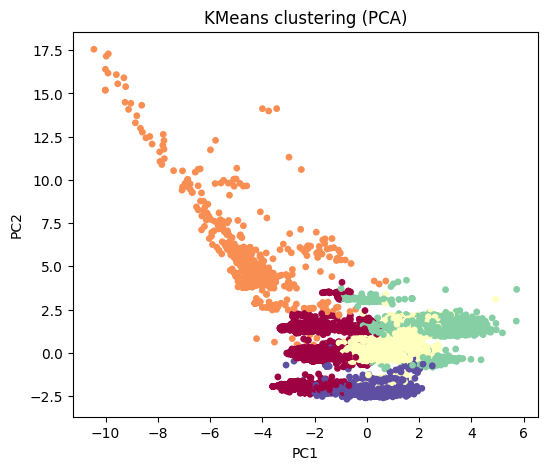

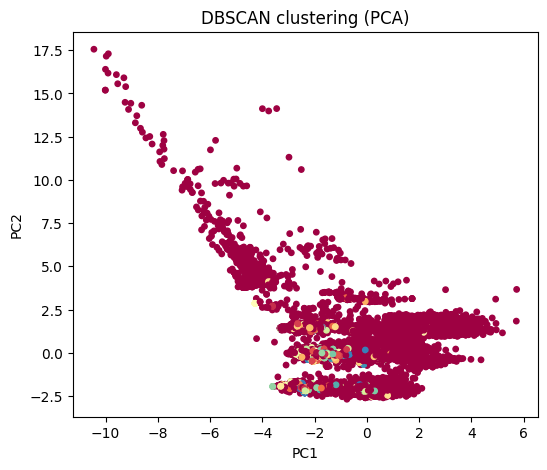

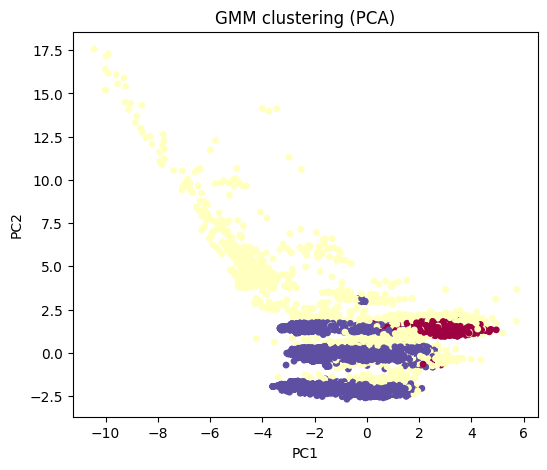

In [42]:
def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='Spectral', s=15)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    print('\n')

plot_clusters(X_pca, labels_kmeans, 'KMeans clustering (PCA)')
plot_clusters(X_pca, labels_dbscan, 'DBSCAN clustering (PCA)')
plot_clusters(X_pca, labels_gmm, 'GMM clustering (PCA)')


In [43]:
def compare_with_true(y_true, labels, name):
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    print(f'{name} |    {ari:.4f}     {nmi:.4f}')

print("Результаты методов кластеризации:")
print("              ARI       NMI")
compare_with_true(y_true, labels_kmeans, 'KMeans')
compare_with_true(y_true, labels_dbscan, 'DBSCAN')
compare_with_true(y_true, labels_gmm, 'GMM')

Результаты методов кластеризации:
              ARI       NMI
KMeans |    0.0071     0.0167
DBSCAN |    0.0371     0.1036
GMM |    0.0058     0.0091


## Вывод:
Для KMeans и GMM значения ARI и NMI близки к нулю, что указывает на отсутствие связи между кластерами и истинными классами. Метод DBSCAN показал немного лучшие результаты метрик, однако значения метрик остаются низкими и не являются значимыми.

Можно подытожить, что в данных отсутствует выраженная кластерная структура, соответствующая целевой переменной, и, следовательно, использование методов кластеризации для восстановления целевой разметки здесь не подходит. С исходными данными лучше решать задачу классификации.